In [1]:
import numpy as np
import pandas as pd
# import tensorflow as tr
# from tensorflow import keras
import os
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Input, Flatten, Conv2D, MaxPool2D,Add
from keras.activations import relu
from keras.optimizers import Adam
from tensorflow.keras.models import Model

from PIL import Image, ImageOps



In [2]:
file =pd.read_csv("data/test_meta-v.csv")
#file paths

#png dataset
test_dir="data/test/"
train_dir="data/train/temp_hold"

#original dicom dataset
org_train_dir="data/original/train"
org_test_dir="data/original/test"
#png datasize same resolution as dicom dataset
variant_dir="data/variant"

#meta record paths
meta_train_dir="data/train_meta-v.csv"
meta_test_dir="data/test_meta-v.csv"
#original record paths
org_train_dir=""
org_test_dir=""

annotation_dir = "data/train.csv"
sample_sub_dir ='data/test.csv'


# DATA EXPLORATION
As the data is in csv's and files we have to ensure the files and entries are equal</br>
Ensuring files and Sheets have equal values


In [3]:
def compareFiles(file_path,record_path):
    #prepare sheets
    data = pd.DataFrame(pd.read_csv(record_path))
    # data.head()
    names = data['image_id'] 
    count =0
    lost={}
    # compare png files and records in the Excel sheets
    with os.scandir(file_path)as files:
        for file in files:
            if(str(file.name)!=str(names[count])+".png"):
                lost.update([(str(file.name),str(names[count]))])
                print("Inconsistent on line "+str(count)+" for image "+str(file.name)+" and record "+str(names[count])+".png")
            count+=1  
    # Records v files may not be equal
    if(count==len(names)):
        print("Files and folders are equal")
        print(str(count)+" "+str(len(names))) 
    elif(count<len(names)):
        print("File missing")
        print("Files: "+str(count)+" Records: "+str(len(names)))
        print(lost)
    elif(count>len(names)):
        print("Record missing")
        print("Files: "+str(count)+" Records: "+str(len(names)))
        print(lost)

compareFiles(test_dir,meta_test_dir)
compareFiles(train_dir,meta_train_dir)

compareFiles(test_dir,sample_sub_dir)


Files and folders are equal
3000 3000
Files and folders are equal
15000 15000
Files and folders are equal
3000 3000


### Compare Images from the three Datasets
First we compare the resoltion of the images from each data set and dplot them using matplotlib


Files found:1


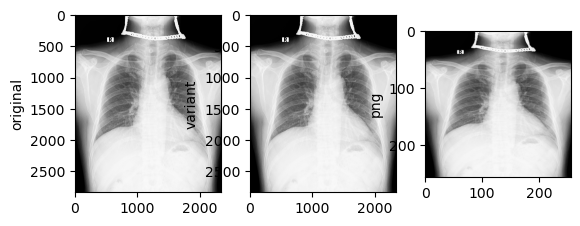

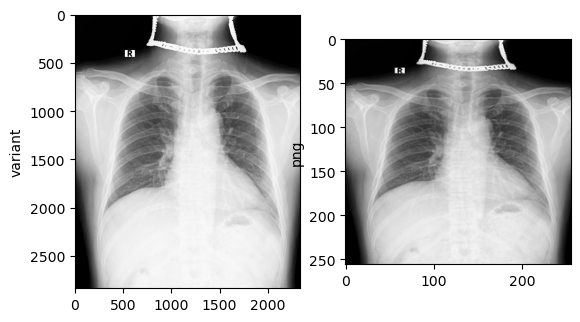

no file matches key
no file matches key
0
no file found


In [5]:
# preprocessing 
# def image-processor(image, size):
# Set mean image size as desired image size for all images in the img list
# Make images black and white  
# def image-processor(image, coords):
# Compare original images and currnet images b-box

#key = 000434271f63a053c4128a0ba6352c7f
#search dir for img matching{----} and draw the b-box on
! pip install pydicom
from os import O_RDONLY
from matplotlib import pyplot as plt
import pydicom as pdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def resolution_compare(key):
    count = 0
    files = os.scandir(train_dir)
    for file in files:
        if(str(file.name)==key+".png" and key =="000434271f63a053c4128a0ba6352c7f"):
            ax, (fig1, fig2, fig3) = plt.subplots(1,3)
            dicom = pdm.dcmread(org_train_dir+"/"+str(key)+".dicom")
            fig1.imshow(dicom.pixel_array,cmap=plt.cm.Greys)
            fig1.set_ylabel("original")

            fig2.imshow(mpimg.imread(variant_dir+"/"+key+".png"),cmap=plt.cm.Greys_r)
            fig2.set_ylabel("variant")

            fig3.imshow(mpimg.imread(train_dir+"/"+key+".png"),cmap =plt.cm.Greys_r)
            fig3.set_ylabel("png")
            # ax.plot(fig1,fig2)
           
            count+=1
            print("Files found:"+ str(count))
            plt.show()

        if(str(file.name)==key+".png"):
            ax, (fig1, fig2) = plt.subplots(1,2)
            fig1.imshow(mpimg.imread(variant_dir+"/"+key+".png"),cmap=plt.cm.Greys_r)
            fig1.set_ylabel("variant")

            fig2.imshow(mpimg.imread(train_dir+"/"+key+".png"),cmap =plt.cm.gray)
            fig2.set_ylabel("png")
            # ax.plot(fig1,fig2)
            plt.show()
        else:
            print("no file matches key")
            break
    if(count==0):
        print(count)
        print("no file found")

resolution_compare(key = "000434271f63a053c4128a0ba6352c7f")
resolution_compare(key ="0a3b8d3f979c06dc7b8ff6cf1f9343e4")


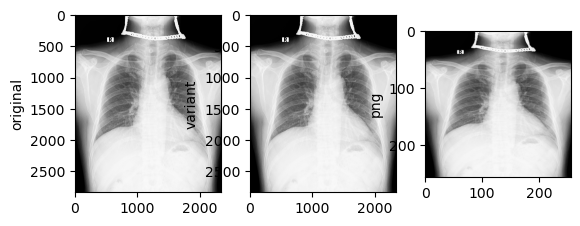

In [16]:
# ! pip install pydicom

# import pydicom as pdm
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# #convert from dicom to png
# key ="000434271f63a053c4128a0ba6352c7f"
# #read the dicom image using pydicom as pdm
# ax, (fig1, fig2, fig3) = plt.subplots(1,3)
# dicom = pdm.dcmread(org_train_dir+"/"+key+".dicom")
# fig1.imshow(dicom.pixel_array,cmap=plt.cm.Greys)
# fig1.set_ylabel("original")

# fig2.imshow(mpimg.imread(variant_dir+"/"+key+".png"),cmap=plt.cm.Greys_r)
# fig2.set_ylabel("variant")

# fig3.imshow(mpimg.imread(train_dir+"/"+key+".png"),cmap=plt.cm.Greys_r)
# fig3.set_ylabel("png")
# # ax.plot(fig1,fig2)
# plt.show()


### EDA on the CSV file
Now we explore and clean the csv file to leverage it for training

In [6]:
#import dataset

train_data = pd.read_csv("data/train - Copy.csv")

train_data.set_index(train_data.index)

# train_data.describe()

# train_data.isna().sum()

#train_data.info()

# train_data.convert_dtypes
# train_data['image_id'].astype(str)

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
67909,936fd5cff1c058d39817a08f58b72cae,No finding,14,R1,NaN,NaN,NaN,NaN
67910,ca7e72954550eeb610fe22bf0244b7fa,No finding,14,R1,NaN,NaN,NaN,NaN
67911,aa17d5312a0fb4a2939436abca7f9579,No finding,14,R8,NaN,NaN,NaN,NaN
67912,4b56bc6d22b192f075f13231419dfcc8,Cardiomegaly,3,R8,771.0,979.0,1680.0,1311.0


In [7]:
healthy = train_data[train_data['class_id']==14].count()
healthy

image_id      31818
class_name    31818
class_id      31818
rad_id        31818
x_min             0
y_min             0
x_max             0
y_max             0
dtype: int64

### Filling in NaN Values

Replaced the NaN values for 0.0's 

In [8]:
values={"x_min":0,"y_min":0,"x_max":0,"y_max":0}
train_data = train_data.fillna(values)
clean_data = train_data
clean_data.head(10)
print(clean_data['image_id'].count())

67914


In [9]:
clean_data['x_center']=(clean_data['x_max']+clean_data['x_min'])/2
clean_data['y_center']=(clean_data['y_max']+clean_data['y_min'])/2

clean_data.head()

clean_data['b_width']  = clean_data['x_max']-clean_data['x_min']
clean_data['b_height'] = clean_data['y_max']-clean_data['y_min']
clean_data.head()

clean_data['b_width']= clean_data['b_width'].replace(np.nan,0)
clean_data['b_height']= clean_data['b_height'].replace(np.nan,0)
clean_data.head()



,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,x_center,y_center,b_width,b_height
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,1172.0,1603.0,962.0,456.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,1437.5,881.0,347.0,276.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
clean_data['class_name'] = clean_data['class_name'].replace('Nodule/Mass','Nodule or Mass')
clean_data.head(10)

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,x_center,y_center,b_width,b_height
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,1172.0,1603.0,962.0,456.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,1437.5,881.0,347.0,276.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0,787.0,395.0,320.0,76.0
6,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347.0,245.0,2188.0,2169.0,1767.5,1207.0,841.0,1924.0
7,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule or Mass,8,R9,557.0,2352.0,675.0,2484.0,616.0,2418.0,118.0,132.0
8,d3637a1935a905b3c326af31389cb846,Aortic enlargement,0,R10,1329.0,743.0,1521.0,958.0,1425.0,850.5,192.0,215.0
9,afb6230703512afc370f236e8fe98806,Pulmonary fibrosis,13,R9,1857.0,1607.0,2126.0,2036.0,1991.5,1821.5,269.0,429.0


In [11]:
new_meta_col=clean_data[['image_id','class_id']]

meta_train = pd.read_csv(meta_train_dir)
print(meta_train.head(5))

meta_test = pd.read_csv(meta_test_dir)
print(meta_test.head(5))

                           image_id  dim0  dim1
0  000434271f63a053c4128a0ba6352c7f  2836  2336
1  00053190460d56c53cc3e57321387478  2430  1994
2  0005e8e3701dfb1dd93d53e2ff537b6e  3072  3072
3  0006e0a85696f6bb578e84fafa9a5607  3000  3000
4  0007d316f756b3fa0baea2ff514ce945  2880  2304
                           image_id  dim0  dim1
0  002a34c58c5b758217ed1f584ccbcfe9  2584  2345
1  004f33259ee4aef671c2b95d54e4be68  3028  2517
2  008bdde2af2462e86fd373a445d0f4cd  2880  2304
3  009bc039326338823ca3aa84381f17f1  2430  1994
4  00a2145de1886cb9eb88869c85d74080  2408  2136


### Convert Rad_id into integer values

In [12]:
#converts rad_id into int values
iter=0
for i in clean_data["rad_id"]:
    if(isinstance(i,int)==True):
        print("Values are already ints eg: "+str(i))
        break
    elif(isinstance(i,str)==True):
        #break text into list 
        y = [*i]
        # print(rad[0])
        #find all instaces of R and replace with blank
        y[y=="R"]=''
        # print(str(rad))
        #join the items to form a number
        y=int(''.join(y))
        # print(y)
        clean_data.at[iter,"rad_id"]=y
        # print(clean_data.at[iter,"rad_id"])
        iter+=1
        
print("done")
    
clean_data.head()

done


,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,x_center,y_center,b_width,b_height
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,10,691.0,1375.0,1653.0,1831.0,1172.0,1603.0,962.0,456.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,10,1264.0,743.0,1611.0,1019.0,1437.5,881.0,347.0,276.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Save Cleaned Data

In [28]:
#save data to external csv
clean_data.to_csv("data/clean_data.csv",encoding='utf8',index=False)

# Split data into train and test

## Read saved data

In [29]:
train_dir
clean_data = pd.read_csv('data/clean_data.csv')
clean_data[7:220]

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,x_center,y_center,b_width,b_height
7,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule or Mass,8,9,557.0,2352.0,675.0,2484.0,616.0,2418.0,118.0,132.0
8,d3637a1935a905b3c326af31389cb846,Aortic enlargement,0,10,1329.0,743.0,1521.0,958.0,1425.0,850.5,192.0,215.0
9,afb6230703512afc370f236e8fe98806,Pulmonary fibrosis,13,9,1857.0,1607.0,2126.0,2036.0,1991.5,1821.5,269.0,429.0
10,7c1add6833d5f0102b0d3619a1682a64,Lung Opacity,7,10,600.0,1332.0,903.0,1523.0,751.5,1427.5,303.0,191.0
11,18a61a07e6f5f13ebfee57fa36cd8b6f,Pulmonary fibrosis,13,9,393.0,283.0,822.0,643.0,607.5,463.0,429.0,360.0
...,...,...,...,...,...,...,...,...,...,...,...,...
215,c0b8111730c30c21085c38b81f432aa9,No finding,14,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
216,57249e369cd43410e8005dc512375ff0,No finding,14,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
217,8036ddc6d564439af50497faef05eec3,Pleural effusion,10,10,496.0,1495.0,583.0,1627.0,539.5,1561.0,87.0,132.0
218,aa1ebd488f7f3cab0aa784073b0a9d70,Other lesion,9,10,1927.0,1393.0,2032.0,1793.0,1979.5,1593.0,105.0,400.0


<AxesSubplot:>

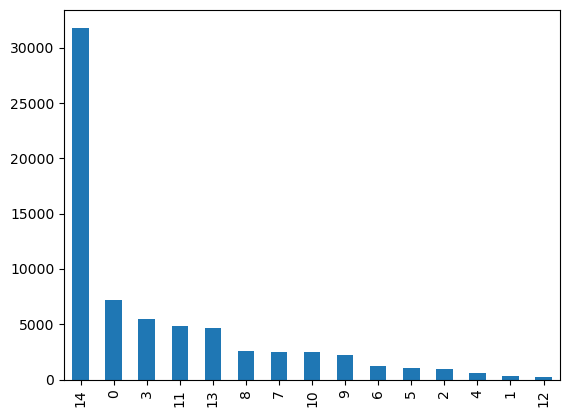

In [17]:
# clean_data.plot(x='class_id',y)
clean_data['class_id'].value_counts().plot(kind='bar')


<AxesSubplot:>

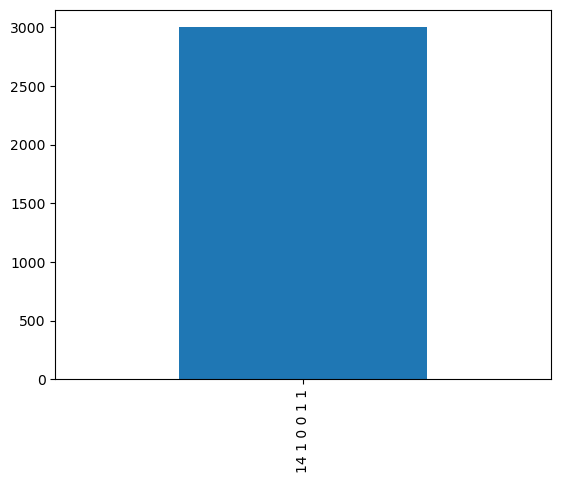

In [18]:
test_data = pd.read_csv('data/test.csv')
test_data.head(10)
test_data['PredictionString'].value_counts().plot(kind='bar')

# Creating Bounding boxes
## Building Bounding boxes 

In [19]:
#create Bounding boxes
from collections import namedtuple
# BoundingBox = namedtuple('Bounding_Box','class_id xmin ymin xmax ymax')

BoundingBox={'xmin':0, 'ymin':0, 'xmax':0, 'ymax':0}
Bounding_Box=[]
# label = namedtuple('label','class_id rad_id xmin ymin xmax ymax')
def buildBoundingBox(key):
    data = clean_data.loc[(clean_data['image_id']==key)]
    # print(data)
    boxes=[]
    count =0
    class_id = np.array(data["class_id"])
    rad_id = np.array(data["rad_id"])
    
    xmin = np.array(data['x_min'])
    ymin = np.array(data['y_min'])
    xmax = np.array(data['x_max'])
    ymax = np.array(data['y_max'])

    if(xmin[0]-xmax[0]==0.0):
        new_class_id = class_id[0]
        new_rad_id = rad_id[0]
        new_ymin = 0.0
        new_xmin = 0.0
        new_xmax = 0.0
        new_ymax = 0.0
        
        # BoundingBox=(new_class_id,new_xmin,new_ymin,new_xmax,new_ymax)
        # BoundingBox={'xmin':new_xmin,'ymin':new_ymin,'xmax':new_xmax,'ymax':new_ymax}
    else:
        for i in range(len(xmax)):
            new_class_id=int(class_id[i])
            new_rad_id=int(rad_id[i])
            new_xmin = int(xmin[i])
            new_ymin = int(ymin[i])
            new_xmax = int(xmax[i])
            new_ymax = int(ymax[i])
            
            # BoundingBox=(new_class_id,new_xmin,new_ymin,new_xmax,new_ymax)
            
            BoundingBox={'class':new_class_id,'xmin':new_xmin,'ymin':new_ymin,'xmax':new_xmax,'ymax':new_ymax}
            
            BoundingBox=[new_class_id,new_xmin,new_ymin,new_xmax,new_ymax]
            boxes.append(BoundingBox)
            # print(label(new_class_id,new_rad_id,new_xmin,new_ymin,new_xmax,new_ymax))
            # print(BoundingBox(new_xmin,new_ymin,new_xmax,new_ymax))
        return boxes
    count+=1
    print(boxes)
    return BoundingBox

buildBoundingBox("321c111713c3ee5385db0effb54ff568")


[[0, 1292, 554, 1477, 805],
 [8, 1748, 669, 1872, 754],
 [2, 1754, 666, 1859, 744],
 [13, 1748, 669, 1872, 754],
 [8, 1758, 664, 1863, 752]]

{'0c7a38f293d5f5e4846aa4ca6db4daf1': [Bounding_Box(xmin=1347, ymin=245, xmax=2188, ymax=2169), Bounding_Box(xmin=87, ymin=196, xmax=1013, ymax=2129), Bounding_Box(xmin=458, ymin=792, xmax=669, ymax=962), Bounding_Box(xmin=161, ymin=56, xmax=2117, ymax=2213), Bounding_Box(xmin=161, ymin=56, xmax=2117, ymax=2213)]}


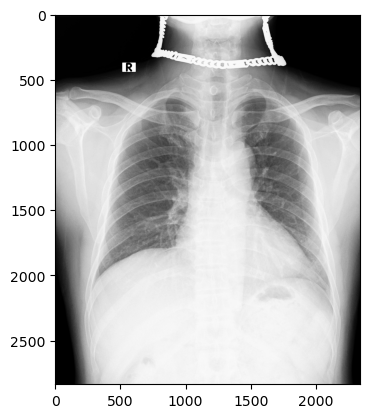

## Resizing the images 
### while factoring in changes to B-boxes

In [1]:
from PIL import Image, ImageOps
TARGET_SIZE=(244,244)
key='321c111713c3ee5385db0effb54ff568'
Bounding_Box = namedtuple('Bounding_Box','xmin ymin xmax ymax')
# boxes=[{'xmin': 1292, 'ymin': 554, 'xmax': 1477, 'ymax': 805},
#  {'xmin': 1748, 'ymin': 669, 'xmax': 1872, 'ymax': 754},
#  {'xmin': 1754, 'ymin': 666, 'xmax': 1859, 'ymax': 744},
#  {'xmin': 1748, 'ymin': 669, 'xmax': 1872, 'ymax': 754},
#  {'xmin': 1758, 'ymin': 664, 'xmax': 1863, 'ymax': 752}]
boxes = [[0, 1292, 554, 1477, 805],
        [8, 1748, 669, 1872, 754],
        [2, 1754, 666, 1859, 744],
        [13, 1748, 669, 1872, 754],
        [8, 1758, 664, 1863, 752]]

def resize_images(path_to_image,bounding_box=None,target_size=None):#,path=None):
    image = Image.open(path_to_image)
    print("Image originally was:"+str(image.size))
    # image = image.convert('L')
    image = image.convert('RGB')
    boxes=[]
    width, height = image.size
    wpad = 0
    hpad = 0
    bonus_hpad = 0
    bonus_wpad = 0

    # the image must be square 
    # the difference between h and w will be filled in by h&w pads
    if width>height:
        difference = (width-height)
        #using floorded division(all dps become 0s)
        hpad = difference // 2
        bonus_h_pad = difference %2
    
    elif height>width:
        difference= height-width
        wpad= difference//2
        bonus_w_pad = difference%2

    #if we pad the image into a sqaure we need to adjust the bounding box values
    # by the amounts added to the left or top

    #The "bonus" pads are always done on the bottom and right
    #so we can ignore them in terms of the box.
    image = ImageOps.expand(image,(wpad,hpad,wpad+bonus_wpad,hpad+bonus_hpad))
    
    # We need to also apply the scaler to the bounding box 
    # which we used in resizing the image
    if bounding_box is not None:
        if type(bounding_box) is list:
          for i in range(len(bounding_box)):
            bounding_box[i][1]+=wpad 
            bounding_box[i][2]+=hpad 
            bounding_box[i][3]+=wpad 
            bounding_box[i][4]+=hpad 

        if type(bounding_box) is dict:
            bounding_box['xmin']+=wpad 
            bounding_box['ymin']+=hpad 
            bounding_box['xmax']+=wpad 
            bounding_box['ymax']+=hpad 
        
    if target_size is not None:
        #since width and height have changed due to the padding resize.
        width,height = image.size
        image = image.resize(target_size)
        width_scale = target_size[0]/width
        height_scale = target_size[1]/height
    
    if bounding_box is not None:
        if type(bounding_box) is list:
          for i in range(len(bounding_box)):
            bounding_box[i][1]+=wpad 
            bounding_box[i][2]+=hpad 
            bounding_box[i][3]+=wpad 
            bounding_box[i][4]+=hpad 

            bounding_box[i][1]*= width_scale
            bounding_box[i][2]*= width_scale
            bounding_box[i][3]*= height_scale
            bounding_box[i][4]*= height_scale
        
        if type(bounding_box) is dict:
            bounding_box['xmin']+=wpad 
            bounding_box['ymin']+=hpad 
            bounding_box['xmax']+=wpad 
            bounding_box['ymax']+=hpad 

            bounding_box['xmin']*= width_scale
            bounding_box['ymin']*= width_scale
            bounding_box['xmax']*= height_scale
            bounding_box['ymax']*= height_scale
    
    image_data = np.array(image.getdata()).reshape(image.size[0],image.size[1],3)
    if bounding_box is None:
        print("image shape became:")
        return image_data,None
    
    
    print("image shape became:"+str(image_data.shape))
    return (image_data,bounding_box)

resize_images(train_dir+"/"+key+".png",boxes,target_size=TARGET_SIZE)

NameError: name 'namedtuple' is not defined

# testing using a Sample

In [228]:
def set_sample(sample_name):
    path_to_image = os.path.join(train_dir, sample_name+'.png')
    original_bounding_box = buildBoundingBox(sample_name)
    image_data,bounding_box = resize_images(path_to_image,original_bounding_box,TARGET_SIZE)#,path='train/')
    # print(image_data.shape)
    return(image_data,bounding_box)
set_sample('00150343289f317a0ad5629d5b7d9ef9')


Image originally was:(256, 256)
image shape became:(244, 244, 3)


(array([[[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        ...,
 
        [[172, 172, 172],
         [176, 176, 176],
         [180, 180, 180],
         ...,
         [135, 135, 135],
         [127, 127, 127],
         [120, 120, 120]],
 
        [[172, 172, 172],
         [176, 176, 176],
         [181, 181, 181],
         ...,
         [136, 136, 136],
         [129, 129, 129],
         [122, 122, 122]],
 
        [[172, 172, 172],
         [175, 175, 175],
         [183, 183, 183],
         ...,
         [139, 139, 139],
  

# Drawing the bounding box on the image

In [2]:
from matplotlib import patches


def plot_with_bbox(image_data,bounding_box,compare_box = None):
    fig,ax = plt.subplots(1)
    ax.imshow(image_data, cmap='Greys_r', vmin=0, vmax=255,interpolation='nearest')
    
    if bounding_box is not None:
      print("No bounding boxes here")
    if bounding_box is not None:
        if type(bounding_box) is list:
            for i in range(len(bounding_box)):
              boxA = patches.Rectangle(
                          (bounding_box[i][1],bounding_box[i][2]),
                          bounding_box[i][3]-bounding_box[i][1],
                          bounding_box[i][4]-bounding_box[i][2],
                          linewidth=3,edgecolor='y',facecolor='none')
              ax.add_patch(boxA)
              # boxA = patches.Rectangle(
              #             (bounding_box[i]['xmin'],bounding_box[i]['ymin']),
              #             bounding_box[i]['xmax']-bounding_box[i]['xmin'],
              #             bounding_box[i]['ymax']-bounding_box[i]['ymin'],
              #             linewidth=3,edgecolor='y',facecolor='none')
              # ax.add_patch(boxA)

            
        
        if type(bounding_box) is dict:
          boxA = patches.Rectangle(
                        (bounding_box['xmin'],bounding_box['ymin']),
                        bounding_box['xmax']-bounding_box['xmin'],
                        bounding_box['ymax']-bounding_box['ymin'],
                        linewidth=3,edgecolor='y',facecolor='none')
          ax.add_patch(boxA)

    if compare_box is not None:
      if type(compare_box) is list:
            for i in range(len(compare_box)):
              boxB = patches.Rectangle(
                          (compare_box[i][1],compare_box[i][2]),
                          compare_box[i][3]-compare_box[i][1],
                          compare_box[i][4]-compare_box[i][2],
                          linewidth=3,edgecolor='y',facecolor='none')
              ax.add_patch(boxB)
             
              # boxB=patches.Rectangle((compare_box.xmin, compare_box.ymin),
              #                         compare_box.xmax - compare_box.xmin,
              #                         compare_box.ymax - compare_box.ymin,
              #                         linewidth=2,edgecolor = 'b',facecolor = 'none')
              # ax.add_patch(boxB)

              #To find intersection fo union
              xA = max(bounding_box[i][1], compare_box[i][1]) 
              yA = max(bounding_box[i][2], compare_box[i][2])
              xB = min(bounding_box[i][3], compare_box[i][3])
              yB = min(bounding_box[i][4], compare_box[i][4])
              
              # xA = max(bounding_box[i]['xmin'], compare_box[i]['xmin']) 
              # yA = max(bounding_box[i]['ymin'], compare_box[i]['ymin'])
              # xB = min(bounding_box[i]['xmax'], compare_box[i]['xmax'])
              # yB = min(bounding_box[i]['ymax'], compare_box[i]['ymax'])
              interArea = max(0,xB-xA+1)*max(0,yB-yA+1)
              boxAArea = (bounding_box[i][3] - bounding_box[i][1] + 1) * \
              (bounding_box[i][4] - bounding_box[i][2] + 1)

              boxBArea = (compare_box.xmax - compare_box.xmin + 1) * \
              (compare_box[i][3] - compare_box[i][1] + 1)
              
              iou = interArea/float(boxAArea+boxBArea-interArea)
              #intersection of union = intersection over union(IOU)itself
              print('intersection of union = ',iou)
              plt.show()
      if type(compare_box) is dict:
        boxB=patches.Rectangle((compare_box['xmin'],compare_box['ymin']),
                                compare_box['xmax']-compare_box['xmin'],
                                compare_box['ymax']-compare_box['ymin'],
                                linewidth=2,edgecolor = 'b',facecolor = 'none')
        ax.add_patch(boxB)

        #To find intersection of union
        xA = max(bounding_box[i][1], compare_box[i][1]) 
        yA = max(bounding_box[i][2], compare_box[i][2])
        xB = min(bounding_box[i][3], compare_box[i][3])
        yB = min(bounding_box[i][4], compare_box[i][4])
        # xA = max(bounding_box.xmin, compare_box.xmin) 
        # yA = max(bounding_box.ymin, compare_box.ymin)
        # xB = min(bounding_box.xmax, compare_box.xmax)
        # yB = min(bounding_box.ymax, compare_box.ymax)

        interArea = max(0,xB-xA+1)*max(0,yB-yA+1)
        boxAArea = (bounding_box[i][3] - bounding_box[i][1] + 1) * \
        (bounding_box[i][4] - bounding_box[i][2] + 1)

        boxBArea = (compare_box[i][3] - compare_box[i][1] + 1) * \
        (compare_box[i][4] - compare_box[i][2] + 1)
        
        iou = interArea/float(boxAArea+boxBArea-interArea)
        #intersection of union = intersection over union(IOU)itself
        print('intersection of union = ',iou)


        if type(compare_box) is dict and type(bounding_box) is list:
          print("dict and list detected: compare box and bounding_box must match")
        if type(compare_box) is list and type(bounding_box) is dict:
          print("list and dict detected: compare box and bounding_box must match")

    plt.show()

    return(image_data)


# Actually testing an image


[]
Image originally was:(256, 256)
image shape became:(244, 244, 3)
No bounding boxes here


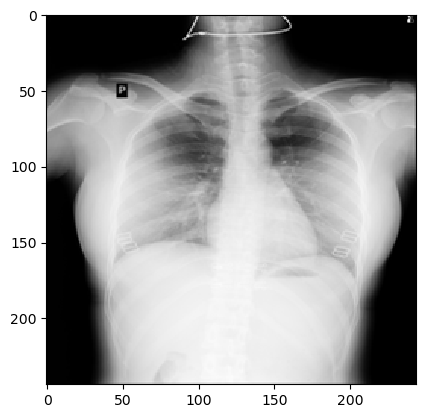

array([[[ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1],
        ...,
        [40, 40, 40],
        [ 4,  4,  4],
        [ 4,  4,  4]],

       [[ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1],
        ...,
        [59, 59, 59],
        [11, 11, 11],
        [ 3,  3,  3]],

       [[ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1],
        ...,
        [45, 45, 45],
        [ 4,  4,  4],
        [ 4,  4,  4]],

       ...,

       [[ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]]])

In [229]:
key = '003cfe5ce5c0ec5163138eb3b740e328'
image, bounding_box =  set_sample(key)

plot_with_bbox( image, bounding_box = bounding_box)

In [64]:
# for file in os.scandir(train_dir):
#     key = file.name.split('.')[0]
#     image, bounding_box =  set_sample(key)
#     # plot_with_bbox( image, bounding_box = bounding_box)
#     path='preprocessed/train'+key+'.png'
#     img = Image.fromarray(image)
#     img = img.SAVE(path)
#     break

Abnormality Labels 

In [87]:
labels ={ 0:"Aortic enlargement",
1:"Atelectasis",
2: "Calcification",
3: "Cardiomegaly",
4: "Consolidation",
5: "ILD",
6: "Infiltration",
7: "Lung Opacity",
8: "Nodule/Mass",
9: "Other lesion",
10: "Pleural effusion",
11: "Pleural thickening",
12: "Pneumothorax",
13: "Pulmonary fibrosis",
14:"No finding"}
print (labels[14])

No finding


In [66]:
%pwd
%mkdir mine

A subdirectory or file mine already exists.


In [ ]:
labels ={ 
    0:"Aortic enlargement",
1:"Atelectasis",
2: "Calcification",
3: "Cardiomegaly",
4: "Consolidation",
5: "ILD",
6: "Infiltration",
7: "Lung Opacity",
8: "Nodule/Mass",
9: "Other lesion",
10: "Pleural effusion",
11: "Pleural thickening",
12: "Pneumothorax",
13: "Pulmonary fibrosis",
14:"No finding"}
print (labels[14])

In [42]:
labels =["Aortic enlargement",
"Atelectasis",
"Calcification",
"Cardiomegaly",
"Consolidation",
"ILD",
"Infiltration",
"Lung Opacity",
"Nodule or Mass",
"Other lesion",
"Pleural effusion",
"Pleural thickening",
"Pneumothorax",
"Pulmonary fibrosis",
"No finding"]
print (labels[14])

No finding


Making folders using the abonormality labels

In [41]:
# %mkdir processed\
#Folders to seperate training and testing images according to their labels

count = 0
def make_folder(path,index):
    if os.path.isdir(path+"/"+labels[index]) is False: 
        os.mkdir(path+"/"+labels[index])

#make folders according to the test_labels
for i in range(15):
    make_folder("processed/train",i)
    i+=1
for j in range(15):
    make_folder("processed/test",j)
    j+=1


NameError: name 'labels' is not defined

# Copy images to appropriate label folder 

In [91]:
import shutil
from pandas import DataFrame
#create Bounding boxes
#png dataset
test_dir="data/test/"
train_dir="data/train/"
#original dicom dataset
org_train_dir="data/original/train"
org_test_dir="data/original/test"
#png datasize same resolution as dicom dataset
variant_dir="data/variant"

new_dir = "processed/"
annotation_dir = "data/train.csv"
data = np.array(clean_data)
count=0
for entry in data:
    img_id = entry[0]
    class_name = entry[1]
    class_id = entry[2]
    org_file = train_dir+img_id+".png"
    new_file = new_dir+"train/"+class_name+"/"+img_id+".png"
    command = "copy "+ org_file+" "+new_file
    if count<len(data):
        if not os.path.exists(new_file):
            try:
                shutil.copy(org_file,new_file)
            except shutil.Error as e:
                print("Error: %s'" % e)
            except IOError as e:
                print("ERROR: %s'" %e.strerror)
            finally:
                print(command)
        else:
            print("already done")
            count+=1
            continue
    else:
        break    
print(count)

already done
already done
already done
already done
already done
already done
already done
copy data/train/47ed17dcb2cbeec15182ed335a8b5a9e.png processed/train/Nodule or Mass/47ed17dcb2cbeec15182ed335a8b5a9e.png
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
copy data/train/8e063eadea9a6aeb684c893c8598be3e.png processed/train/Nodule or Mass/8e063eadea9a6aeb684c893c8598be3e.png
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
copy data/train/d106ec9b305178f3da060efe3191499a.png pro

# split data

In [142]:
# !pip install split-folders
import splitfolders
splitfolders.ratio( 
    "data/train","data/",seed=123,
    ratio=(.8,.2),
    group_prefix=None,
    move=False
)

SameFileError: 'data\\train\\temp_hold\\abc012252fe22c8e6b94a02baf6a8d71.png' and 'data/train\\temp_hold\\abc012252fe22c8e6b94a02baf6a8d71.png' are the same file

<https://machinelearningmastery.com/three-ways-to-build-machine-learning-models-in-keras/>


In [136]:
training_data = "processed/preprocessed/train"
testing_data = "processed/preprocessed/test"
validation_data="processed/preprocessed/val"
print(validation_data)


processed/preprocessed/val


In [138]:
labels =["Aortic enlargement",
"Atelectasis",
"Calcification",
"Cardiomegaly",
"Consolidation",
"ILD",
"Infiltration",
"Lung Opacity",
"Nodule or Mass",
"Other lesion",
"Pleural effusion",
"Pleural thickening",
"Pneumothorax",
"Pulmonary fibrosis",
"No finding"]
print (labels[14])

No finding


# Preprocessing input

In [178]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator 
# Preprocessing the images in the dataset
train_batch= ImageDataGenerator(preprocessing_function= tf.keras.applications.resnet50.preprocess_input)\
.flow_from_directory(directory=training_data,target_size=(244,244),classes=labels,batch_size=8)

valid_batch=ImageDataGenerator(preprocessing_function= tf.keras.applications.resnet50.preprocess_input)\
.flow_from_directory(directory=validation_data,target_size=(244,244), classes=labels, batch_size=8, shuffle=False)
test_batch=ImageDataGenerator(preprocessing_function= tf.keras.applications.resnet50.preprocess_input)\
.flow_from_directory(directory=testing_data,target_size=(244,244), classes=labels, batch_size=8, shuffle=False)


Found 18174 images belonging to 15 classes.
Found 5189 images belonging to 15 classes.
Found 2608 images belonging to 15 classes.


In [100]:
def preprocess_dir(dir):
    files = os.scandir(dir)
    for file in files:
        key = file.name.split('.')[0]
        full_path = dir+"/"+file.name
        image_data=resize_images(full_path)
        image_data.save(dir+'/resized/'+key+'.png')

preprocess_dir('processed/preprocessed/train/ILD')

AttributeError: 'numpy.ndarray' object has no attribute 'save'

There are different types of layers : 
Dense layer connects input and output layers
convolutional layers better for image processing
Pooling layers
Recurrent layers better for time series
Normalization Layers


In [96]:
# def residual_block(x,filters):
#     identity = x
#     x = Conv2D(filters=filters,kernel_size=(3,3), strides = (1,1), padding="same")(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.activations.relu(x)
#     x = Conv2D(filters=filters,kernel_size=(3,3), padding ="same")(x)
#     x = Add()([identity,x])
#     x = relu(x)
#     return x

Demo   VGG16

In [ ]:
# import tensorflow as tf
# from tensorflow import keras
# from keras.layers import Dense, Input, Flatten, Conv2D, MaxPool2D,Add
# from keras.activations import relu
# from keras.optimizers import Adam
# from tensorflow.keras.models import Model
# #input layer
# input_layer = Input(shape=(244,244,1))
# #first convolutional layer
# x = Conv2D(filters=32,kernel_size=(3,3),padding="same", activation="relu")(input_layer)
# #first residual block
# x = residual_block(x,32)
# #secondd convolutional layer
# x = Conv2D(filters=64, kernel_size=(3,3),strides=(2,2),padding="same",activation="relu")(x)
# # second residual layer
# x = residual_block(x,64)
# #third convolutional layer
# x = Conv2D(filters=128,kernel_size=(3,3),strides=(2,2),padding="same",activation="relu")(x)
# #first slattening layer
# x = Flatten()(x)
# #first dense layer
# x = Dense(units=84, activation ="relu")(x)
# #second dense layer
# x = Dense(units=10, activation = "softmax")(x)

# #create model without pur in form of X
# model = Model(inputs=input_layer, outputs = x)
# print(model.summary())

In [179]:

#the identity block is used where the input and the output tensors are excatly the same size 
#any change in size will cause a numpy error:
#two objects fo different sizes cannot be added  

def IdentityBlock(x,filter):
    #copy the tensor variable to x_skip 
    x_skip = x
    #layer1
    x_skip = Conv2D(filters=filter,kernel_size=(3,3),padding='same')(x)
    x_skip = tf.keras.layers.BatchNormalization(axis=3)(x)
    x_skip = tf.keras.layers.Activation('relu')(x)
    #layer2
    x_skip = Conv2D(filters=filter,kernel_size=(3,3),padding='same')(x)
    x_skip = tf.keras.layers.BatchNormalization(axis=3)(x)
    #layer3
    x_skip = tf.keras.layers.Add()([x,x_skip])
    x_skip = tf.keras.layers.Activation('relu')(x)
    return x


to calculate the size of output relative to input:
((x+2p-k)/s)+1
(input+ 2 padding_size - kernel_size )/ strides + 1
input is 244 p=1 k=3 s=1 output=((244 + 2 -3)/1)+1=244
padding will automaticaally be calcualted by keras to keep output same as input

In [180]:
def ConvolutionalBlock(x, filter):
    #save input
    x_skip=x
    #layer 1
    x = tf.keras.layers.Conv2D(filter,kernel_size=(3,3),padding='same',strides=(2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    #layer 2
    x = tf.keras.layers.Conv2D(filter,kernel_size=(3,3),padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    #Process residue in conv(1x1)
    x_skip = tf.keras.layers.Conv2D(filter,kernel_size=(1,1),strides=(2,2),padding='same')(x_skip)
    #add residue
    x = tf.keras.layers.Add()([x,x_skip])
    x=tf.keras.layers.Activation('relu')(x)
    return x


![image](markdown\resnet-denominations.jpg "Text to show on mouseover").

# https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8

In [181]:

def ResNet50(shape = (244,244,3), classes = 15):
    #Input layer
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    #Conv layer an maxpool layer
    x = tf.keras.layers.Conv2D(64,kernel_size=7 ,strides=1,padding='same',)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3,strides=2,padding='same')(x)
    # According to the structure of the Resnet the layers follow a specific pattern
    # One convolutionalBlock followed by three Identityblocks as demonstrated in the above diagram
    #specify the multiplication sequence the resnet followsa as the blocks progress
    block_layers=[3,4,6,3]
    filter_size=64
    #the resnet had five layers
    for i in range(4):
        # the first layer is an identity block
        if i==0:
            for j in range(block_layers[i]):
               x = IdentityBlock(x,filter_size) 
        # the pattern of convolutional block & three identityblocks
        # happens three times
        else:
            # filter size per iteration scales by a factor of two
            filter_size*=2
            x = ConvolutionalBlock(x,filter_size)
            for j in range(block_layers[i]-1):
                x = IdentityBlock(x,filter_size)
    x = tf.keras.layers.AveragePooling2D((2,2),padding='same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512,activation='relu')(x)
    x = tf.keras.layers.Dense(classes, activation='softmax')(x)
    model = tf.keras.models.Model(inputs=x_input,outputs=x,name="ResNet50") 
    return model
    # x=tf.keras.layers.AveragePooling2D()(x)

model = ResNet50((244,244,1),len(labels))
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "ResNet34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 244, 244, 1  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 250, 250, 1)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 250, 250, 64  3200        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                           

In [182]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [183]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(\
    filepath='./model.{epoch:02d}-{val_accuracy:.2f}.hdf5',\
    save_weights_only=False,\
    monitor='val_accuracy'
)

In [184]:
model.fit(train_batch,batch_size =10,epochs=3,validation_data =valid_batch,validation_batch_size=10)

Epoch 1/3


InvalidArgumentError: Graph execution error:

Detected at node 'ResNet34/conv2d/BiasAdd' defined at (most recent call last):
    File "c:\Users\Samson\anaconda3\envs\deep_learning\lib\runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "c:\Users\Samson\anaconda3\envs\deep_learning\lib\runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "c:\Users\Samson\anaconda3\envs\deep_learning\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\Samson\anaconda3\envs\deep_learning\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\Users\Samson\anaconda3\envs\deep_learning\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\Samson\anaconda3\envs\deep_learning\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Samson\anaconda3\envs\deep_learning\lib\asyncio\base_events.py", line 541, in run_forever
      self._run_once()
    File "c:\Users\Samson\anaconda3\envs\deep_learning\lib\asyncio\base_events.py", line 1786, in _run_once
      handle._run()
    File "c:\Users\Samson\anaconda3\envs\deep_learning\lib\asyncio\events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Samson\anaconda3\envs\deep_learning\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\Samson\anaconda3\envs\deep_learning\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\Samson\anaconda3\envs\deep_learning\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\Samson\anaconda3\envs\deep_learning\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\Samson\anaconda3\envs\deep_learning\lib\site-packages\ipykernel\ipkernel.py", line 390, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "c:\Users\Samson\anaconda3\envs\deep_learning\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Samson\anaconda3\envs\deep_learning\lib\site-packages\IPython\core\interactiveshell.py", line 2915, in run_cell
      raw_cell, store_history, silent, shell_futures)
    File "c:\Users\Samson\anaconda3\envs\deep_learning\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "c:\Users\Samson\anaconda3\envs\deep_learning\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Samson\anaconda3\envs\deep_learning\lib\site-packages\IPython\core\interactiveshell.py", line 3186, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "c:\Users\Samson\anaconda3\envs\deep_learning\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "c:\Users\Samson\anaconda3\envs\deep_learning\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Samson\AppData\Local\Temp\ipykernel_17004\881455029.py", line 1, in <module>
      model.fit(train_batch,batch_size =10,epochs=3,validation_data =valid_batch,validation_batch_size=10)
    File "c:\Users\Samson\anaconda3\envs\deep_learning\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Samson\anaconda3\envs\deep_learning\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\Samson\anaconda3\envs\deep_learning\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "c:\Users\Samson\anaconda3\envs\deep_learning\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Samson\anaconda3\envs\deep_learning\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "c:\Users\Samson\anaconda3\envs\deep_learning\lib\site-packages\keras\engine\training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\Samson\anaconda3\envs\deep_learning\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Samson\anaconda3\envs\deep_learning\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\Samson\anaconda3\envs\deep_learning\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Samson\anaconda3\envs\deep_learning\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Samson\anaconda3\envs\deep_learning\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Samson\anaconda3\envs\deep_learning\lib\site-packages\keras\engine\functional.py", line 459, in call
      inputs, training=training, mask=mask)
    File "c:\Users\Samson\anaconda3\envs\deep_learning\lib\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\Samson\anaconda3\envs\deep_learning\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Samson\anaconda3\envs\deep_learning\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Samson\anaconda3\envs\deep_learning\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Samson\anaconda3\envs\deep_learning\lib\site-packages\keras\layers\convolutional\base_conv.py", line 270, in call
      outputs, self.bias, data_format=self._tf_data_format)
Node: 'ResNet34/conv2d/BiasAdd'
output depth must be evenly divisible by number of groups: 64 vs 3
	 [[{{node ResNet34/conv2d/BiasAdd}}]] [Op:__inference_train_function_4175]